In [38]:
import os
import pandas as pd
import plotly.graph_objects as go
import sqlalchemy
from sqlalchemy import create_engine, func

In [12]:
# Define the destination folder and database path
destination_folder = 'data'
database_filename = 'faostat_data.sqlite'
destination_path = os.path.join(destination_folder, database_filename)

# Create an SQLite engine
engine = create_engine(f'sqlite:///{destination_path}')

In [13]:
# Sum of each crop by country and year
query = """
SELECT Area, Item, Year, SUM(Value) AS Total_Production
FROM qcl
GROUP BY Area, Item, Year
ORDER BY Area, Year, Total_Production DESC
"""

crop_production_by_year = pd.read_sql(query, con=engine)

print(crop_production_by_year)

              Area                  Item  Year  Total_Production
0      Afghanistan  Cattle and Buffaloes  1961           2900000
1      Afghanistan      Green corn/Maize  1961            500000
2      Afghanistan                  Rice  1961            210000
3      Afghanistan  Cattle and Buffaloes  1962           3200000
4      Afghanistan      Green corn/Maize  1962            500000
...            ...                   ...   ...               ...
45429     Zimbabwe  Cattle and Buffaloes  2022           5438771
45430     Zimbabwe      Green corn/Maize  2022           1001819
45431     Zimbabwe            Soya beans  2022             38177
45432     Zimbabwe         Coffee, green  2022              2645
45433     Zimbabwe                  Rice  2022              2144

[45434 rows x 4 columns]


In [16]:
# SQL query
query = """
SELECT 
    SUM([Land area]) AS total_land_area,
    SUM(Cropland + [Permanent meadows and pastures] + [Farm buildings and Farmyards]) AS total_agricultural_land,
    SUM([Other land]) AS total_other_land,
    SUM([Forest land]) AS total_forest_land,
    SUM(Unaccounted) AS total_unaccounted,
    SUM(Cropland) AS total_cropland,
    SUM([Permanent meadows and pastures]) AS total_pastures,
    SUM([Farm buildings and Farmyards]) AS total_farm_buildings
FROM rl
WHERE Year = 2022;
"""

# Execute the query and load the result into a DataFrame
result = pd.read_sql(query, con=engine)

# Display the result
print(result)

   total_land_area  total_agricultural_land  total_other_land  \
0     1.301516e+07             4.797674e+06      4.159900e+06   

   total_forest_land  total_unaccounted  total_cropland  total_pastures  \
0       4.048946e+06          8641.2704    1.573345e+06      3207689.78   

   total_farm_buildings  
0            16639.1134  


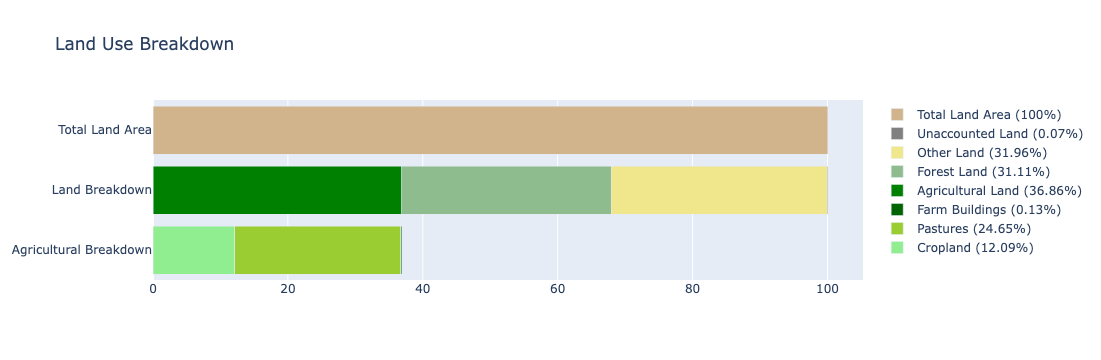

In [93]:
# Function to calculate percentages
def calc_percentage(value, total):
    return (value / total) * 100

# Percentages relative to the total land area
def calc_percentage(value):
    return (value / total_land_area) * 100

# Land category percentages
perc_cropland = calc_percentage(total_cropland)
perc_pastures = calc_percentage(total_pastures)
perc_farm_buildings = calc_percentage(total_farm_buildings)

perc_agricultural_land = calc_percentage(total_agricultural_land)
perc_forest_land = calc_percentage(total_forest_land)
perc_other_land = calc_percentage(total_other_land)
perc_unaccounted = calc_percentage(total_unaccounted)

# Creating the figure
fig = go.Figure()

# Agricultural Breakdown (Cropland, Pastures, Farm Buildings as a percentage of total agricultural land)
fig.add_trace(go.Bar(
    y=['Agricultural Breakdown'],
    x=[perc_cropland],
    name=f'Cropland ({perc_cropland:.2f}%)',
    orientation='h',
    marker=dict(color='lightgreen'),
    hovertemplate='<br>Cropland<br>%{x:.2f}%<extra></extra>'
))

fig.add_trace(go.Bar(
    y=['Agricultural Breakdown'],
    x=[perc_pastures],
    name=f'Pastures ({perc_pastures:.2f}%)',
    orientation='h',
    marker=dict(color='yellowgreen'),
    base=perc_cropland,
    hovertemplate='<br>Pastures<br>%{x:.2f}%<extra></extra>'
))

fig.add_trace(go.Bar(
    y=['Agricultural Breakdown'],
    x=[perc_farm_buildings],
    name=f'Farm Buildings ({perc_farm_buildings:.2f}%)',
    orientation='h',
    marker=dict(color='darkgreen'),
    base=perc_cropland + perc_pastures,
    hovertemplate='<br>Farm Buildings<br>%{x:.2f}%<extra></extra>'
))

# Land Breakdown (Agricultural Land, Forest, Other, Unaccounted as a percentage of total land area)
fig.add_trace(go.Bar(
    y=['Land Breakdown'],
    x=[perc_agricultural_land],
    name=f'Agricultural Land ({perc_agricultural_land:.2f}%)',
    orientation='h',
    marker=dict(color='green'),
    hovertemplate='<br>Agricultural Land<br>%{x:.2f}%<extra></extra>'
))

fig.add_trace(go.Bar(
    y=['Land Breakdown'],
    x=[perc_forest_land],
    name=f'Forest Land ({perc_forest_land:.2f}%)',
    orientation='h',
    marker=dict(color='darkseagreen'),
    base=perc_agricultural_land,
    hovertemplate='<br>Forest Land<br>%{x:.2f}%<extra></extra>'
))

fig.add_trace(go.Bar(
    y=['Land Breakdown'],
    x=[perc_other_land],
    name=f'Other Land ({perc_other_land:.2f}%)',
    orientation='h',
    marker=dict(color='khaki'),
    base=perc_agricultural_land + perc_forest_land,
    hovertemplate='<br>Other Land (habitable, infrastructure, glaciers, deserts, etc.)<br>%{x:.2f}%<extra></extra>'
))

fig.add_trace(go.Bar(
    y=['Land Breakdown'],
    x=[perc_unaccounted],
    name=f'Unaccounted Land ({perc_unaccounted:.2f}%)',
    orientation='h',
    marker=dict(color='gray'),
    base=perc_agricultural_land + perc_forest_land + perc_other_land,
    hovertemplate='<br>Unaccounted<br>%{x:.2f}%<extra></extra>'
))

# Total Land Area
fig.add_trace(go.Bar(
    y=['Total Land Area'],
    x=[100],
    name='Total Land Area (100%)',
    orientation='h',
    marker=dict(color='tan'),
    hovertemplate='<br>Total Land<br>%{x:.2f}%<extra></extra>'
))

# Update layout to show labels as percentages
fig.update_layout(
    title='Land Use Breakdown',
    barmode='stack',
#    xaxis=dict(title='Percentage'),
#    yaxis=dict(title='Land Categories'),
    showlegend=True
)

# Show the figure
fig.show()